In [58]:
from openslide import OpenSlide, lowlevel 
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
from PIL import Image, ImageDraw


import xml.etree.ElementTree as ET

In [59]:
# Define the path for the slides & labels
slides_path = '/Users/gabriel.jimenez/Documents/project/AT8Dataset/AT8_wsi/'
labels_path = '/Users/gabriel.jimenez/Documents/project/AT8Dataset/AT8_XML_annotations/'

slide_name = 'FAD-APP 717L_P42-06_AT8.ndpi'
label_name = 'FAD-APP 717L_P42-06_AT8.xml'

# Opening the slide image
slide = lowlevel.open(slides_path+slide_name)
keys = lowlevel.get_property_names(slide)
val = lowlevel.get_property_value(slide,keys[-1])

#for i in range(len(keys)):
    #print(i, " :: ", keys[i], " : ", lowlevel.get_property_value(slide, keys[i]))

offsetX = int(lowlevel.get_property_value(slide, 'hamamatsu.XOffsetFromSlideCentre')) # THIS IS IN NANOMETERS!
offsetY = int(lowlevel.get_property_value(slide, 'hamamatsu.YOffsetFromSlideCentre')) # THIS IS IN NANOMETERS!

resX = float(lowlevel.get_property_value(slide, 'openslide.mpp-x')) # THIS IS IN MICRONS/PIXEL FOR LVL 0!
resY = float(lowlevel.get_property_value(slide, 'openslide.mpp-y')) # THIS IS IN MICRONS/PIXEL FOR LVL 0!

In [60]:
slide = OpenSlide(slides_path+slide_name)
# Getting slide level dimentions
slide_levels = slide.level_dimensions

# Printing important information about the current slide
print("[INFO] The slide have ", len(slide_levels), " magnification levels:")
for i in range(len(slide_levels)):
    print("   Level ", i, " with dimensions (in pixels) : ", slide_levels[i])

# Chosing the magnification level
slide_dim_lvl = 5

# Getting the thumbnail for slide
thm = slide.read_region((0, 0), slide_dim_lvl, slide_levels[slide_dim_lvl])

[INFO] The slide have  9  magnification levels:
   Level  0  with dimensions (in pixels) :  (119040, 93440)
   Level  1  with dimensions (in pixels) :  (59520, 46720)
   Level  2  with dimensions (in pixels) :  (29760, 23360)
   Level  3  with dimensions (in pixels) :  (14880, 11680)
   Level  4  with dimensions (in pixels) :  (7440, 5840)
   Level  5  with dimensions (in pixels) :  (3720, 2920)
   Level  6  with dimensions (in pixels) :  (1860, 1460)
   Level  7  with dimensions (in pixels) :  (930, 730)
   Level  8  with dimensions (in pixels) :  (465, 365)


In [61]:
''' 
From nano/micro meters to pixel language :) 
Larger value is X axis (-->)
'''
dimsSlide = np.array(slide_levels[0])*[resX,resY] # this is in micrometers :)
centerPx_X, centerPx_Y = np.array(slide_levels[0])/2
_, factor = np.array(slide_levels[0])/np.array(slide_levels[slide_dim_lvl])

sizeX, sizeY = np.array(slide_levels[0])/factor

# Loading the slide annotations from XML file
tree = ET.parse(labels_path+label_name)
root = tree.getroot()

# Preparing the annotation container
labels = []

# Getting the annotaiton coordinates from the XML file
for boxes in root:
    for obejcts in boxes:
        type_object = int(obejcts.attrib['Type'])
        for vertices in obejcts:
            temp_obj = []
            for vertex in vertices:
                y_mm = float(vertex.attrib['Y']) # this is in milimeters!
                x_mm = float(vertex.attrib['X']) # this is in milimeters!
                y_p_offset = (y_mm)*1000 - (abs(offsetY)/1000) # this is in micrometers!
                x_p_offset = (x_mm)*1000 - (abs(offsetX)/1000) # this is in micrometers!
                y_newCenter = y_p_offset + int(centerPx_Y)*resY # this is in micrometers!
                x_newCenter = x_p_offset + int(centerPx_X)*resX # this is in micrometers!
                y = (y_newCenter/resY)/factor # pixels
                x = (x_newCenter/resX)/factor # pixels

                ''' Flip '''
                y = abs(sizeY - y)
                #x = sizeX - x

                temp_obj.append([x, y])
            labels.append([type_object, np.array(temp_obj)])



[INFO] The whole-slide image with the gray matter annotation (dim level 5 )


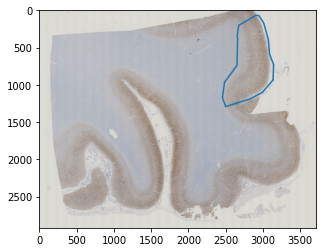

In [62]:

# Overlaying the first object (Gray matter annotation)
print("\n[INFO] The whole-slide image with the gray matter annotation (dim level", slide_dim_lvl, ")")
plt.figure()
plt.imshow(thm)
plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])

plt.show()


[INFO] The whole-slide image with the gray matter annotation (dim level 5 )


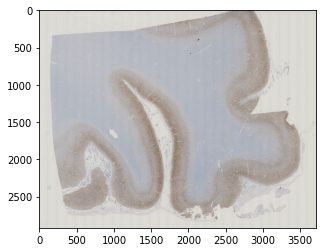

8


In [63]:
# Overlaying the first object (Gray matter annotation)
print("\n[INFO] The whole-slide image with the gray matter annotation (dim level", slide_dim_lvl, ")")
plt.figure()
plt.imshow(thm)
for obj, coordinates in labels:
    if obj == 1 and i == 14:
        #print(coordinates)
        plt.plot(coordinates[:, 0], coordinates[:, 1])
#plt.xlim((2250, 3400))
#plt.ylim((0, 1350))
#plt.gca().invert_yaxis()
plt.show()
print(i)

In [64]:
# Creating a polygone
polygon_patch = Polygon(labels[0][1])

# Getting the bounding box of the label
coords_region = list(polygon_patch.bounds)

# Getting the size of the label
size = (int(coords_region[2]-coords_region[0])+1, int(coords_region[3]-coords_region[1])+1)

# Extracting the region of the label from the whole-slide-image
region = slide.read_region((int(coords_region[0]*factor), int(coords_region[1]*factor)), slide_dim_lvl, (size[0], size[1]))


1


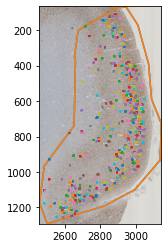

In [65]:
# Plotting the label along side the croped version of the whole slide image
print(labels[0][0])
plt.figure()
plt.imshow(thm)
plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])
for obj, coordinates in labels:
    plt.plot(coordinates[:, 0], coordinates[:, 1])

plt.xlim((coords_region[0], coords_region[2]))
plt.ylim((coords_region[3], coords_region[1]))
#plt.xlim((0, 5000))
#plt.ylim((0, 2500))
#plt.gca().invert_yaxis()

plt.show()

In [66]:
i = 0
plotFlag = 0
background_ratio_vec = []
area_obj_vec = []
area_patch_vec = []
#plt.figure()
for obj, coordinates in labels:
    if obj == 1: # this are the annotations by Lev.
        polygon_obj = Polygon(coordinates)
        coords_obj = list(polygon_obj.bounds)
        size_obj = (int(coords_obj[2]-coords_obj[0])+1, int(coords_obj[3]-coords_obj[1])+1)
        region_obj = slide.read_region((int(coords_obj[0]*factor), int(coords_obj[1]*factor)), slide_dim_lvl, (size_obj[0], size_obj[1]))
        
        if i > 275 and plotFlag == 1:
            plt.imshow(thm)
            plt.plot(coordinates[:, 0], coordinates[:, 1])
            plt.xlim((coords_obj[0], coords_obj[2]))
            plt.ylim((coords_obj[3], coords_obj[1]))
            plt.show()
        
        area_obj = polygon_obj.area
        area_patch = size_obj[0]*size_obj[1]
        background_percentage = area_obj/area_patch

        area_obj_vec.append(area_obj)
        area_patch_vec.append(area_patch)
        background_ratio_vec.append(background_percentage*100)

        i+=1
print(i)


15


max area obj:  517965.95082862314
max patch obj:  845403


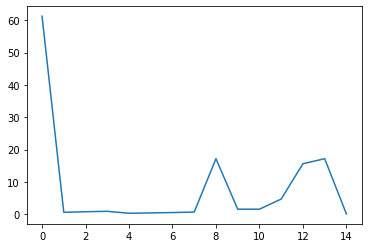

In [67]:
print("max area obj: ", max(area_obj_vec))
print("max patch obj: ", max(area_patch_vec))


plt.figure()
plt.plot(background_ratio_vec)
plt.show()

In [69]:
# Creating mask for the WSI

i = 0
plotFlag = 0
background_ratio_vec = []
area_obj_vec = []
area_patch_vec = []

mask = Image.new('L', (int(sizeX), int(sizeY)), 0)

for obj, coordinates in labels:
    if obj == 1: # this are the annotations by Lev.
        something = coordinates.tolist()
        tuples = [tuple(x) for x in something]

        polygon_obj = Polygon(coordinates)
        coords_obj = list(polygon_obj.bounds)
        size_obj = (int(coords_obj[2]-coords_obj[0])+1, int(coords_obj[3]-coords_obj[1])+1)
        region_obj = slide.read_region((int(coords_obj[0]*factor), int(coords_obj[1]*factor)), slide_dim_lvl, (size_obj[0], size_obj[1]))
        
        ImageDraw.Draw(mask).polygon(tuples, outline=1, fill=1)

        i+=1

mask_WSI = np.array(mask)


print(i)

15


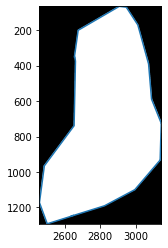

In [70]:
mask_WSI = (mask_WSI>0).astype("uint8")
plt.figure()
plt.imshow(mask_WSI, cmap = "gray")
plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])

plt.xlim((coords_region[0], coords_region[2]))
plt.ylim((coords_region[3], coords_region[1]))
plt.show()

519256


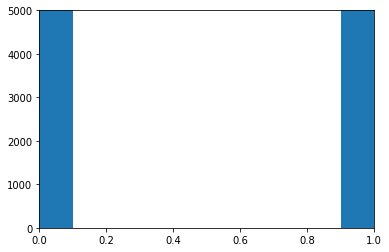

In [71]:
print(sum(mask_WSI.astype("uint8").flatten()))
plt.hist(mask_WSI.astype("uint8").flatten())
plt.ylim(0, 5000)
plt.xlim(0, 1)
plt.show()

In [72]:
# Creating mask for the WSI

i = 0
plotFlag = 0

coords_list = []

mask = Image.new('L', (int(sizeX), int(sizeY)), 0)

for obj, coordinates in labels:
    if obj == 1: # this are the annotations by Lev.
        something = coordinates.tolist()
        tuples = [tuple(x) for x in something]

        polygon_obj = Polygon(coordinates)
        coords_obj = list(polygon_obj.bounds)
        #size_obj = (int(coords_obj[2]-coords_obj[0])+1, int(coords_obj[3]-coords_obj[1])+1)
        
        coords_list.append(coords_obj)
        
        #region_obj = slide.read_region((int(coords_obj[0]*factor), int(coords_obj[1]*factor)), slide_dim_lvl, (size_obj[0], size_obj[1]))
        
        #ImageDraw.Draw(mask).polygon(tuples, outline=1, fill=1)

        i+=1

#mask_WSI = np.array(mask)


print(i)

15


In [153]:
patchSize = [800, 1310] # [cols, rows]
from matplotlib import cm

# mask_WSI: has all the masks for the annotations and is the same size as the WSI.
# slide: is the original WSI in the level selected.
# labels: annotations from XML.
# coords_list: list of coordinates of annotated objects.
k = 0
for coords in coords_list:
    if k == 0:
        size_obj = [int(coords[2]-coords[0])+1, int(coords[3]-coords[1])+1]
        new_region_size = np.array(patchSize) - np.array(size_obj)
        print(new_region_size)
        print(size_obj)

        new_coords = (coords[0]-new_region_size[0]/2, coords[1]-new_region_size[1]/2, coords[2]+new_region_size[0]/2, coords[3]+new_region_size[1]/2)
        print(new_coords)

        new_region_obj = slide.read_region((int(new_coords[0]*factor), int(new_coords[1]*factor)), slide_dim_lvl, (patchSize[0], patchSize[1]))
        new_mask_obj = Image.fromarray(mask_WSI*255).crop((int(new_coords[0]),int(new_coords[1]),int(new_coords[0]+patchSize[0]),int(new_coords[1]+patchSize[1])))

        k += 1


[111  83]
[689, 1227]
(2401.570277144687, 24.402529838124792, 3200.705711185, 1333.6171031873437)


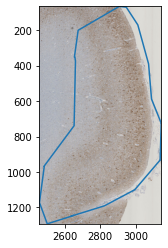

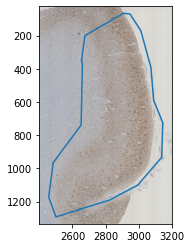

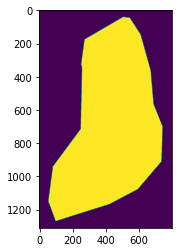

In [154]:
#new_mask_array = np.array(new_mask_obj)
#new_mask_array = (new_mask_array>0).astype("uint8")
plt.figure()
plt.imshow(thm, cmap = "gray")
plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])

#plt.xlim((new_coords[0], new_coords[2]))
#plt.ylim((new_coords[3], new_coords[1]))
plt.xlim((coords_region[0], coords_region[2]))
plt.ylim((coords_region[3], coords_region[1]))
plt.show()

plt.figure()
plt.imshow(thm, cmap = "gray")
plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])

plt.xlim((new_coords[0], new_coords[2]))
plt.ylim((new_coords[3], new_coords[1]))
#plt.xlim((coords_region[0], coords_region[2]))
#plt.ylim((coords_region[3], coords_region[1]))
plt.show()

plt.figure()
plt.imshow(new_mask_obj)
#plt.plot(labels[0][1][:, 0], labels[0][1][:, 1])

#plt.xlim((new_coords[0], new_coords[2]))
#plt.ylim((new_coords[3], new_coords[1]))
#plt.xlim((coords_region[0], coords_region[2]))
#plt.ylim((coords_region[3], coords_region[1]))
plt.show()

In [110]:
new_mask_obj.show()

In [145]:
(int(new_coords[0]),patchSize[0]-1,int(new_coords[1]),patchSize[1]-1)

(2457, 688, 65, 1226)

In [146]:
(int(new_coords[0])+patchSize[0]-1,int(new_coords[1])+patchSize[1]-1)

(3145, 1291)

In [147]:
(sizeX, sizeY)

(3720.0, 2920.0)